# Predecessor Problem

In [1]:
import sys
import os
import random
import collections
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from keras import regularizers
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

Using TensorFlow backend.


## Reproducibility
This settings will allow us to reproduce our results.

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Creating the dataset

### Parameters

In [3]:
window = 1000
predecessors_number = 2
matrix_shape = 2
offset = 71
training_percentage = 0.8
testing_percentage = 1 - training_percentage

In [8]:
dataset = np.array([(j, i * window) for i in range(predecessors_number)
                    for j in range(i * window, (i + 1) * window)]) + offset
dataset.shape

(2000, 2)

In [5]:
np.random.shuffle(dataset)
N = int(np.float(dataset.shape[0] * training_percentage))
training, testing = dataset[:N], dataset[N:]
x, y = training.T
x_test, y_test = testing.T

## Data fitting
Here we normalize data reshaping them

In [6]:
training_x = x.reshape(-1, 1).astype(float)
testing_x = x_test.reshape(-1, 1).astype(float)
scaler = StandardScaler().fit(training_x)

## Data normalization

In [7]:
normalized_training = scaler.transform(training_x)
normalized_testing = scaler.transform(testing_x)
normalized_training

array([[ 1.51209178],
       [-1.09880703],
       [ 0.59905683],
       ...,
       [ 0.89531674],
       [-0.04890346],
       [ 1.54847457]])

Creating training labels

In [8]:
TRAINING_POSITIVE_NUMBERS = int(window * predecessors_number * training_percentage)
training_labels = np.zeros((len(normalized_training), matrix_shape))
np.set_printoptions(threshold = np.nan)
training_labels[:TRAINING_POSITIVE_NUMBERS,0] = np.ones((TRAINING_POSITIVE_NUMBERS))
training_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

Creating testing labels

In [9]:
TESTING_POSITIVE_NUMBERS = int(window * predecessors_number * testing_percentage)
testing_labels = np.zeros((len(normalized_testing), matrix_shape))
testing_labels[:TESTING_POSITIVE_NUMBERS, 1] = np.ones((TESTING_POSITIVE_NUMBERS))
testing_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

## Defining function to create the model
First Layer has 5 neurons, selu activation and input dimension = 1.
Hidden Layer has 5 neurons, selu activation.
Output Layer has 2 neurons and sigmoid activation.

In [23]:
def build_model():
    """ Return keras network model """
    model = Sequential()
    model.add(Dense(5, input_dim=15, name="Input_dense_layer"))
    model.add(Activation("sigmoid", name="Input_Sigmoid"))

    model.add(Dense(5, name="Hidden_dense_layer"))
    model.add(Activation("sigmoid", name="Hidden_Sigmoid"))

    model.add(Dense(2, name="Output_dense_layer"))
    model.add(Activation("sigmoid", name="Output_Sigmoid"))

    model.compile(
        loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Network Metrics
Such as history graphs, ROCs, confusion matrix and a summary

In [24]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(
        history.history[index],
        label='Training %s = %0.6f' % (label,
                                       history.history['val_%s' % index][-1]))
    plt.title('Model %s' % label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')

In [25]:
def plot_model_roc(training_labels, training_prediction, testing_labels,
                   testing_prediction):
    """Plot roc graph from given labels and predictions."""
    plt.plot(
        *roc_curve(training_labels, training_prediction)[:2],
        label='Training ROC curve (area = %0.6f)' % roc_auc_score(
            training_labels, training_prediction))
    plt.plot(
        *roc_curve(testing_labels, testing_prediction)[:2],
        label='Testing ROC curve (area = %0.6f)' % roc_auc_score(
            testing_labels, testing_prediction))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC)', fontsize=15)
    plt.legend(loc="lower right")

In [26]:
def plot_model_prc(training_labels, training_prediction, testing_labels,
                   testing_prediction):
    """Plot Precision-Recall curve"""
    plt.plot(
        *precision_recall_curve(training_labels, training_predction)[:2],
        label='Training average precision = %0.6f' % average_precision_score(
            training_labels, training_prediction))
    plt.plot(
        *precision_recall_curve(testing_labels, testing_prediction)[:2],
        label='Testing average precision = %0.6f' % average_precision_score(
            testing_labels, testing_prediction))
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.title('2-class Precision-Recall curve (PRC)', fontsize=15)

## Definition of plotting functions

In [27]:
import itertools


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, roation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.6f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
def plot_summary_statistics(model, history, training, testing, training_labels, testing_labels):
    # We print a summary of the progress
    training_prediction = model.predict_proba(training)
    testing_prediction = model.predict_proba(testing)

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 4, 1)
    plot_history_graph(history, 'acc', 'accuracy')
    plt.subplot(2, 4, 2)
    plot_history_graph(history, 'loss', 'loss')
    plt.subplot(2, 4, 3)
    plot_model_roc(training_labels, training_prediction, testing_labels,
                   testing_prediction)
    plt.subplot(2, 4, 4)
    plot_model_prc(training_labels, training_prediction, testing_labels,
                   testing_prediction)
    plt.subplot(2, 4, 5)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(training_labels, training_prediction.round())

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        title='Training Confusion matrix, without normalization')
    plt.subplot(2, 4, 6)
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        normalize=True,
        title='Training Confusion matrix normalized')
    plt.subplot(2, 4, 7)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(testing_labels, testing_prediction.round())

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        title='Testing Confusion matrix, without normalization')
    plt.subplot(2, 4, 8)
    plot_confusion_matrix(
        cnf_matrix,
        classes=["Negatives", "Positives"],
        normalize=True,
        title='Testing Confusion matrix normalized')
    plt.show()

## Building of the model

In [29]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 5)                 80        
_________________________________________________________________
Input_Sigmoid (Activation)   (None, 5)                 0         
_________________________________________________________________
Hidden_dense_layer (Dense)   (None, 5)                 30        
_________________________________________________________________
Hidden_Sigmoid (Activation)  (None, 5)                 0         
_________________________________________________________________
Output_dense_layer (Dense)   (None, 2)                 12        
_________________________________________________________________
Output_Sigmoid (Activation)  (None, 2)                 0         
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


## Running the model

In [30]:
history = model.fit(
    normalized_training,
    training_labels,
    epochs=5,
    shuffle=True,
    batch_size=16,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(normalized_testing, testing_labels)
)

ValueError: Error when checking input: expected Input_dense_layer_input to have shape (15,) but got array with shape (1,)

In [18]:
model.save("model")
model.save_weights("weights")
#plot_summary_statistics(model, history, normalized_training,
 #                       normalized_testing, training_labels,
  #                      testing_labels)

## Making predictions

In [19]:
training_prediction = model.predict_proba(normalized_training)
testing_prediction = model.predict_proba(normalized_testing)
testing_prediction

array([[0.97241086, 0.11195948],
       [0.9723159 , 0.11179592],
       [0.97203267, 0.11188398],
       [0.9724181 , 0.11198968],
       [0.9724392 , 0.11210795],
       [0.9719697 , 0.11192404],
       [0.9723885 , 0.11189017],
       [0.97188777, 0.11197832],
       [0.9721291 , 0.11182836],
       [0.9724177 , 0.11198755],
       [0.9724381 , 0.11210088],
       [0.9723274 , 0.11180288],
       [0.97224766, 0.11178551],
       [0.9721253 , 0.11183035],
       [0.9723832 , 0.11187784],
       [0.9720042 , 0.11190184],
       [0.9718788 , 0.11198436],
       [0.9723414 , 0.11181439],
       [0.9719366 , 0.11194573],
       [0.97235155, 0.11182525],
       [0.9719954 , 0.11190743],
       [0.97219115, 0.11180026],
       [0.9722116 , 0.11179335],
       [0.97211874, 0.11183385],
       [0.97207403, 0.11185899],
       [0.97202027, 0.11189169],
       [0.972162  , 0.11181235],
       [0.9719462 , 0.11193942],
       [0.97231525, 0.11179554],
       [0.9720425 , 0.11187796],
       [0.

## Plotting loss and accuracy

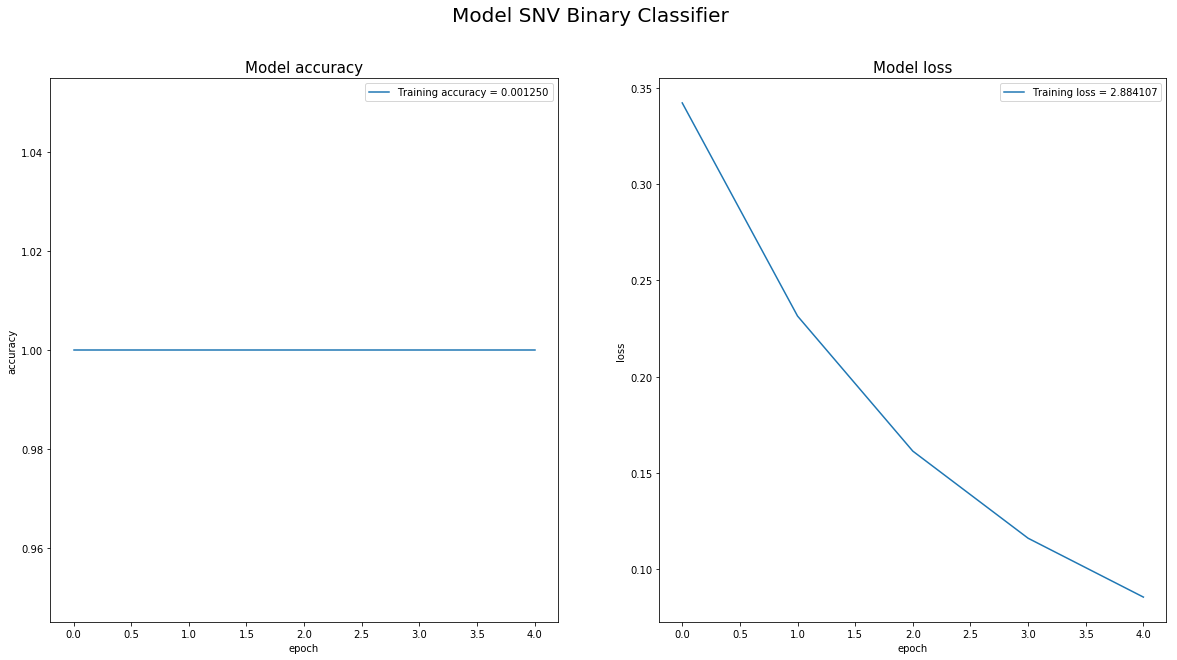

In [20]:
plt.figure(figsize=(20,10))
plt.suptitle("Model SNV Binary Classifier", fontsize=20)
plt.subplot(1, 2, 1)
plot_history_graph(history, 'acc', 'accuracy')
plt.subplot(1, 2, 2)
plot_history_graph(history, 'loss', 'loss')
plt.show()

## Plotting ROC and PRC

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plot_model_roc(training_labels, training_prediction, testing_labels,
               testing_prediction)
plt.subplot(1, 2, 2)
plot_model_prc(training_labels, training_prediction, testing_labels,
               testing_prediction)
plt.show()

## Confusion matrix for training set

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(training_labels, training_prediction.round())

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=["Negatives", "Positives"],
                      title='Training Confusion matrix, without normalization')
plt.subplot(1,2,2)
plot_confusion_matrix(cnf_matrix, classes=["Negatives", "Positives"], normalize=True,
                      title='Training Confusion matrix normalized')
plt.show()

## Confusion matrix for testing set

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
# Compute confusion matrix
cnf_matrix = confusion_matrix(testing_labels, testing_prediction.round())

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=["Negatives", "Positives"],
                      title='Testing Confusion matrix, without normalization')
plt.subplot(1,2,2)
plot_confusion_matrix(cnf_matrix, classes=["Negatives", "Positives"], normalize=True,
                      title='Testing Confusion matrix normalized')
plt.show()

